2025-05-27 11:59:31.335020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 11:59:31.335051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 11:59:31.336053: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 11:59:31.341350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 11:59:31.849274: W tensorflow/compiler/tf2

2025-05-27 11:59:34,320 - WARNING - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
2025-05-27 11:59:34,321 - INFO - Loaded generator model from generator_final.h5
2025-05-27 11:59:34.788481: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-05-27 11:59:34.826994: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-05-27 11:59:35.270915: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


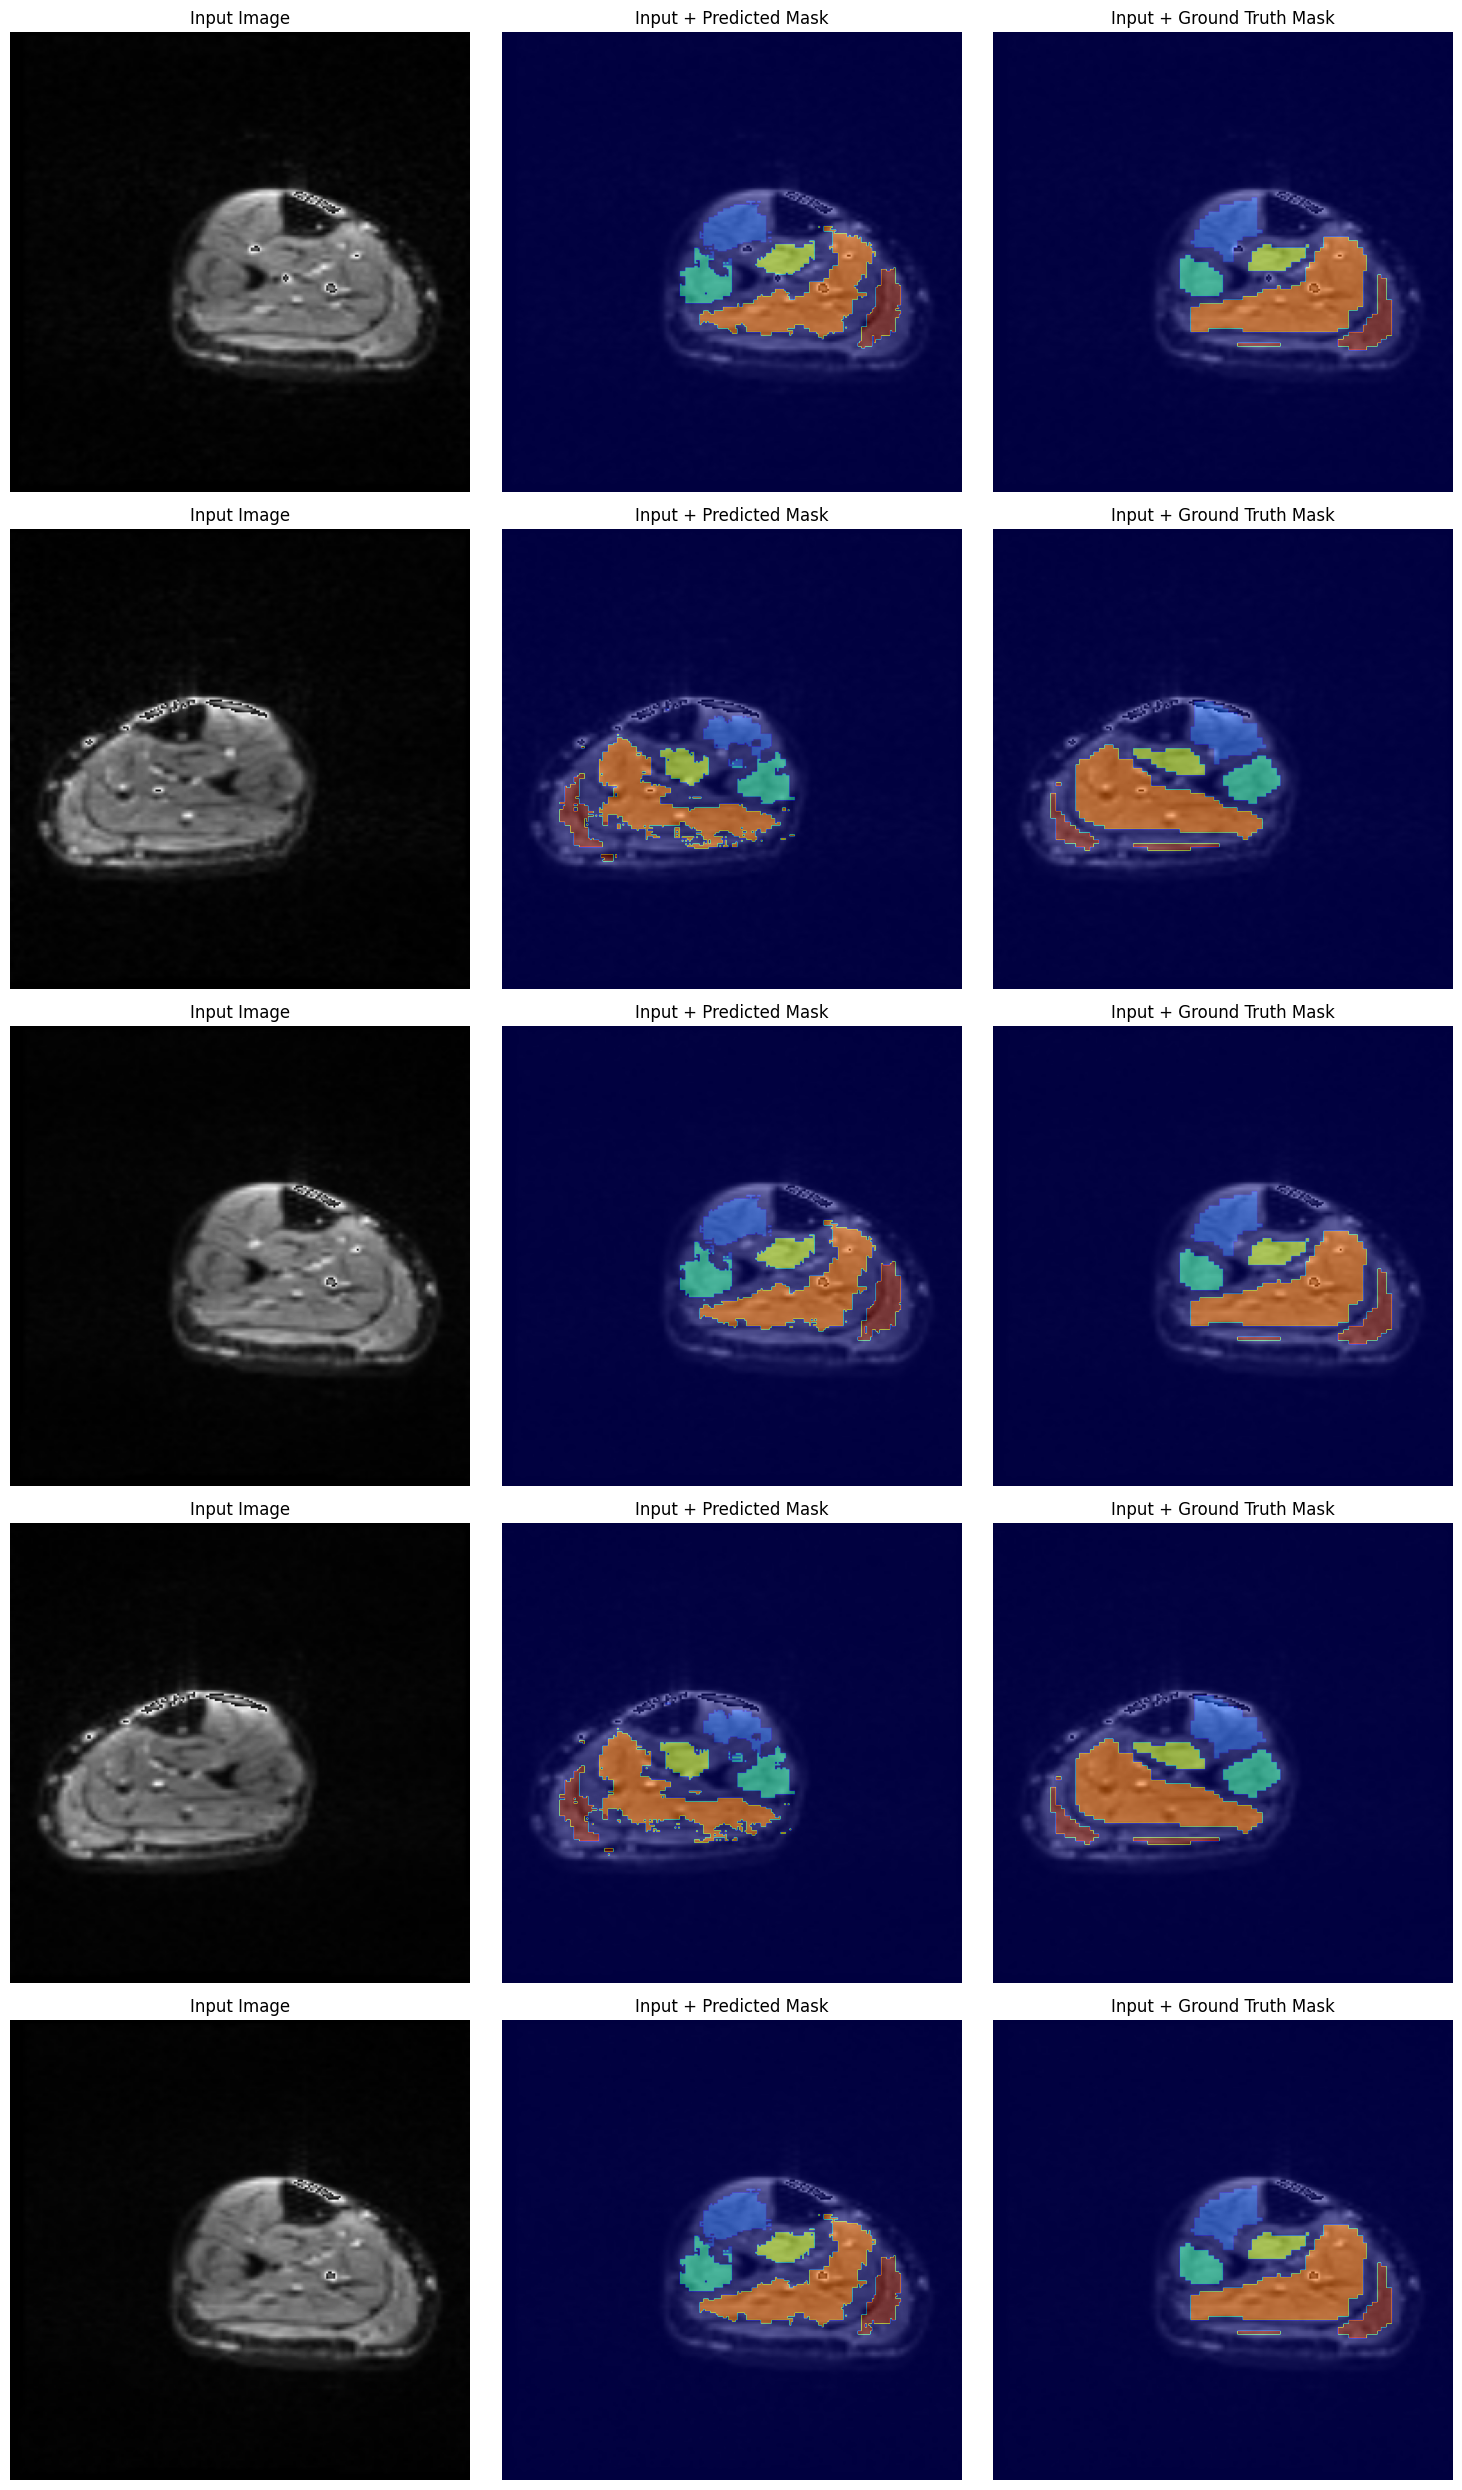

2025-05-27 11:59:37,946 - INFO - Saved test results visualization to test_results.png


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logging
from pathlib import Path

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('test.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Constants
IMG_WIDTH = 256
IMG_HEIGHT = 256
INPUT_CHANNELS = 1  # Single-channel grayscale input
OUTPUT_CHANNELS = 6  # One-hot encoded ROI
BATCH_SIZE = 16

# Data preprocessing
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    return input_image

# Load test data
def load_test_data():
    try:
        path = '/home/besanhalwa/Eshan/project1_PMRI/Data/npy_tech_pmri_pad_no_aug_leftRight_split/'
        test_images = np.load(path+'test_images.npy')
        test_roi = np.load(path+'test_masks_hot_encoded.npy')
        
        # Ensure images have 1 channel
        if test_images.ndim == 3:
            test_images = np.expand_dims(test_images, axis=-1)
        
        return test_images, test_roi
    except Exception as e:
        logger.error(f"Failed to load test data: {e}")
        raise

# Create tf.data dataset for testing
def create_test_dataset(test_images, test_roi):
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_roi))
    test_dataset = (test_dataset
                    .map(lambda x, y: (normalize(x), y), num_parallel_calls=tf.data.AUTOTUNE)
                    .batch(BATCH_SIZE)
                    .prefetch(tf.data.AUTOTUNE))
    return test_dataset

# Convert one-hot encoded mask to single-channel integer mask
def one_hot_to_integer_mask(one_hot_mask):
    """
    Convert a one-hot encoded mask (..., 256, 256, 6) to a single-channel integer mask (..., 256, 256)
    with values from 0 to 5.
    """
    return tf.argmax(one_hot_mask, axis=-1, output_type=tf.int32)

# Display input image with overlaid segmentation mask
def display_overlay(input_image, predicted_mask, ground_truth_mask=None, num_samples=5):
    """
    Display input images with predicted segmentation masks overlaid.
    Optionally display ground truth masks if provided.
    """
    # Convert to numpy and remove batch dimension if necessary
    input_image = input_image.numpy()
    predicted_mask = predicted_mask.numpy()
    if ground_truth_mask is not None:
        ground_truth_mask = ground_truth_mask.numpy()
    
    # Ensure we process only up to num_samples
    num_samples = min(num_samples, input_image.shape[0])
    
    # Create a colormap for the segmentation mask
    cmap = plt.get_cmap('jet')  # Use jet colormap for distinct colors
    norm = plt.Normalize(vmin=0, vmax=OUTPUT_CHANNELS-1)
    
    # Set up figure
    cols = 3 if ground_truth_mask is not None else 2
    fig, axes = plt.subplots(num_samples, cols, figsize=(cols * 5, num_samples * 5))
    if num_samples == 1:
        axes = np.array([axes])  # Ensure axes is 2D for consistent indexing
    
    for i in range(num_samples):
        # Denormalize input image to [0, 1] for display
        img = (input_image[i, ..., 0] + 1) * 0.5  # Grayscale, remove channel dimension
        
        # Predicted mask
        pred_mask = predicted_mask[i]
        
        # Plot input image
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        # Plot input with overlaid predicted mask
        axes[i, 1].imshow(img, cmap='gray')
        axes[i, 1].imshow(pred_mask, cmap=cmap, norm=norm, alpha=0.5)  # Overlay with transparency
        axes[i, 1].set_title('Input + Predicted Mask')
        axes[i, 1].axis('off')
        
        # Plot ground truth mask if provided
        if ground_truth_mask is not None:
            gt_mask = ground_truth_mask[i]
            axes[i, 2].imshow(img, cmap='gray')
            axes[i, 2].imshow(gt_mask, cmap=cmap, norm=norm, alpha=0.5)
            axes[i, 2].set_title('Input + Ground Truth Mask')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('test_results.png')
    plt.show()
    logger.info("Saved test results visualization to test_results.png")

def main():
    try:
        # Load the model
        model_path = 'generator_final.h5'
        if not Path(model_path).exists():
            raise FileNotFoundError(f"Model file {model_path} not found")
        generator = tf.keras.models.load_model(model_path)
        logger.info(f"Loaded generator model from {model_path}")
        
        # Load test data
        test_images, test_roi = load_test_data()
        test_dataset = create_test_dataset(test_images, test_roi)
        
        # Generate predictions
        for input_images, ground_truth_roi in test_dataset.take(1):  # Take one batch
            predictions = generator(input_images, training=False)
            
            # Convert one-hot predictions to integer masks
            predicted_masks = one_hot_to_integer_mask(predictions)
            ground_truth_masks = one_hot_to_integer_mask(ground_truth_roi)
            
            # Display results
            display_overlay(input_images, predicted_masks, ground_truth_masks, num_samples=5)
            break  # Process only one batch for visualization
        
    except Exception as e:
        logger.error(f"Testing failed: {e}")
        raise

if __name__ == "__main__":
    main()